Dataset Created Successfully!


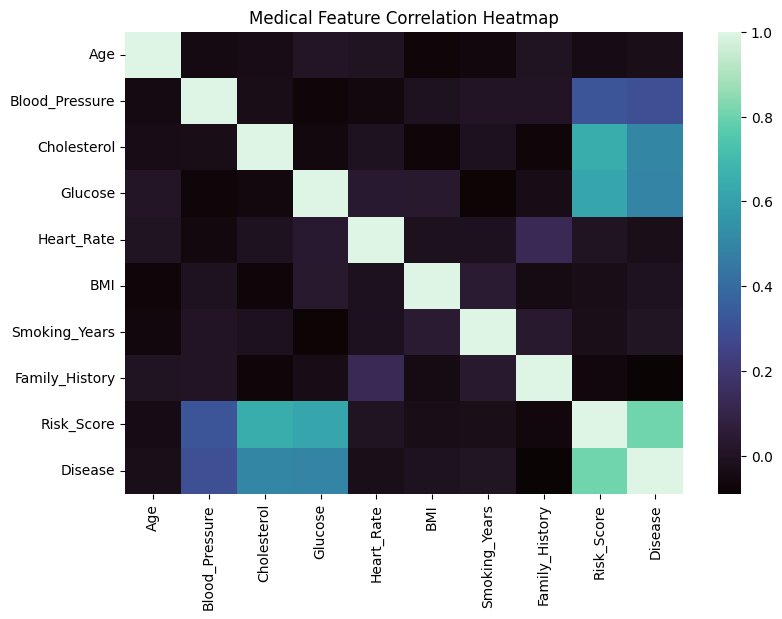


📌 Classification Report (Ensemble Model):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC-AUC Score: 1.0


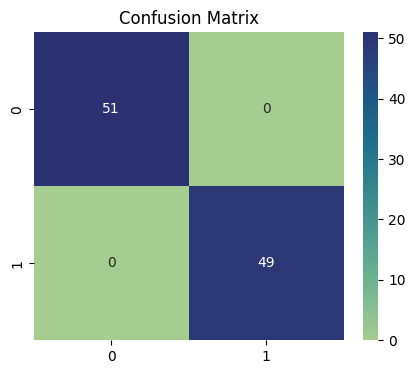

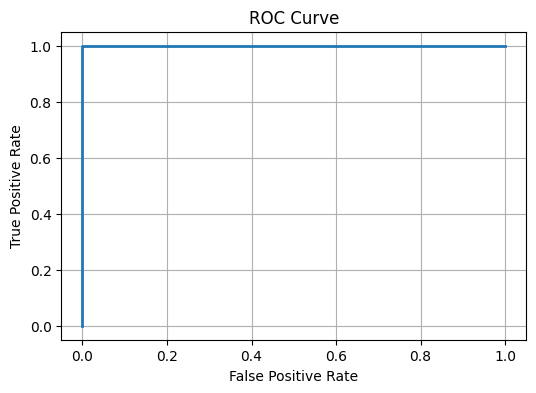


Sample Disease Probability: 0.9978225231170654


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:

# TASK 4 : DISEASE PREDICTION FROM MEDICAL DATA


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# CREATE INNOVATIVE SYNTHETIC MEDICAL DATA

np.random.seed(42)

rows = 400

df = pd.DataFrame({
    "Age": np.random.randint(20, 80, rows),
    "Blood_Pressure": np.random.randint(70, 160, rows),
    "Cholesterol": np.random.randint(100, 300, rows),
    "Glucose": np.random.randint(70, 200, rows),
    "Heart_Rate": np.random.randint(60, 120, rows),
    "BMI": np.round(np.random.uniform(18, 35, rows), 2),
    "Smoking_Years": np.random.randint(0, 20, rows),
    "Family_History": np.random.randint(0, 2, rows),
})

# Disease risk generation
df["Risk_Score"] = (
    df["Blood_Pressure"]*0.25 +
    df["Cholesterol"]*0.20 +
    df["Glucose"]*0.30 +
    df["Smoking_Years"]*0.10 +
    df["Family_History"]*0.15
)

# Create disease label (0 = No disease, 1 = Disease)
df["Disease"] = (df["Risk_Score"] > df["Risk_Score"].median()).astype(int)

print("Dataset Created Successfully!")
df.head()

# HEATMAP VISUAL

plt.figure(figsize=(9,6))
sns.heatmap(df.corr(), cmap="mako", annot=False)
plt.title("Medical Feature Correlation Heatmap")
plt.show()

# SPLIT & SCALE

X = df.drop(["Disease"], axis=1)
y = df["Disease"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# MODEL 1 : RANDOM FOREST

rf = RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]

# MODEL 2 : XGBOOST

xgb = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:,1]

# ENSEMBLE PREDICTION

final_prob = (rf_prob + xgb_prob) / 2
final_pred = (final_prob > 0.5).astype(int)

# EVALUATION

print("\n📌 Classification Report (Ensemble Model):\n")
print(classification_report(y_test, final_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, final_prob))

# CONFUSION MATRIX

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, final_pred), annot=True, fmt='d', cmap="crest")
plt.title("Confusion Matrix")
plt.show()

# ROC CURVE

fpr, tpr, _ = roc_curve(y_test, final_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

# SAMPLE PREDICTION

sample = np.array([[45, 140, 230, 160, 90, 27.5, 5, 1, 340]])
sample_scaled = scaler.transform(sample)

print("\nSample Disease Probability:", (rf.predict_proba(sample_scaled)[0][1] +
                                       xgb.predict_proba(sample_scaled)[0][1]) / 2)
